# StackGP System in Python
## By: Nathan Haut

### Implementation Notes

This implementation evolves models of the form model = [operator Stack, Variable Constant Stack, ..., [QualityMetrics]].


In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
from scipy.stats import pearsonr # for computing correlation
from functools import reduce #for flattening lists
from operator import concat  #for flattening lists
import warnings
import time
warnings.filterwarnings('ignore', '.*invalid value.*' )
warnings.filterwarnings('ignore', '.*overflow.*' )
warnings.filterwarnings('ignore', '.*divide by.*' )
warnings.filterwarnings('ignore', '.*is constant.*' )
warnings.filterwarnings('ignore', '.*nearly constant.*' )
warnings.filterwarnings('ignore', '.*Polyfit may be.*' )
def protectDiv(a,b):
    
    if (type(b)==int or type(b)==float or type(b)==np.float64) and b==0:
        return a/math.nan
    if (type(b)==np.ndarray) and (0 in b):
        return a/np.where(b==0,math.nan,b)
    return a/b
def add(a,b):
    return a+b
def sub(a,b):
    return a-b
def mult(a,b):
    return a*b
def exp(a):
    return np.exp(a)
# def sine(a,b):
#     return np.sin(a)
def power(a,b):
    return a**b
def sqrt(a):
    return np.sqrt(a)
def sqrd(a):
    return a**2
def inv(a):
    return np.array(a).astype(float)**(-1)
def sin(a):
    return np.sin(a)
def cos(a):
    return np.cos(a)
def tan(a):
    return np.tan(a)
def arccos(a):
    return np.arccos(a)
def arcsin(a):
    return np.arcsin(a)
def arctan(a):
    return np.arctan(a)
def tanh(a):
    return np.tanh(a)
def log(a):
    np.log(a)





def defaultOps():
    return [protectDiv,add,sub,mult,exp,sqrd,sqrt,inv,"pop","pop","pop","pop","pop","pop"]
def allOps():
    return [protectDiv,add,sub,mult,exp,sqrd,sqrt,inv,cos,sin,tan,arccos,arcsin,arctan,tanh,log,"pop","pop","pop","pop","pop","pop","pop","pop","pop","pop"]
def randomInt(a=-3,b=3):
    return random.randint(a,b)
def defaultConst():
    return [np.pi, np.e, randomInt,ranReal ]
def ranReal(a=20,b=-10):
    return random.random()*a-b

In [2]:
import inspect
def getArity(func): #Returns the arity of a function: used for model evaluations
    if func=="pop":
        return 1
    return len(inspect.signature(func).parameters)

getArity.__doc__ = "getArity(func) takes a function and returns the function arity"

def modelArity(model): #Returns the total arity of a model
    return 1+sum([getArity(i)-1 for i in model[0]])

modelArity.__doc__ = "modelArity(model) returns the total arity of a model"

def listArity(data): #Returns arity of evaluating a list of operators
    if len(data)==0:
        return 0
    return 1+sum([getArity(i)-1 for i in data])

listArity.__doc__ = "listArity(list) returns the arity of evaluating a list of operators"

def buildEmptyModel(): # Generates an empty model
    return [[],[],[]]

buildEmptyModel.__doc__ = "buildEmptyModel() takes no inputs and generates an empty GP model"

def variableSelect(num): #Function that creates a function to select a specific variable
    return lambda variables: variables[num]

variableSelect.__doc__ = "variableSelect(n) is a function that creates a function to select the nth variable"


In [3]:
def generateRandomModel(variables,ops,const,maxLength):  #Generates a random GP model
    prog = buildEmptyModel()                             #Generate an empty model with correct structure
    varChoices=[variableSelect(i) for i in range(variables)]+const                           #All variable and constants choices
    prog[0]=np.random.choice(ops,random.randint(1,maxLength)) #Choose random operators
    countVars=modelArity(prog)    #Count how many variables/constants are needed
    prog[1]=np.random.choice(varChoices,countVars)       #Choose random variables/constants
    prog[1]=[i() if (callable(i) and i.__name__!='<lambda>' )else i for i in prog[1]] #If function then evaluate
    return prog

generateRandomModel.__doc__ = "generateRandomModel() takes as input the variables, operators, constants, and max program length and returns a random program"

def initializeGPModels(variables,ops=defaultOps(),const=defaultConst(),numberOfModels=100,maxLength=10): # generate random linear program
    prog=[[],[],[]]
    # prog stores [Operators, VarConst, QualityMetrics]
    
    models=[generateRandomModel(variables,ops,const,maxLength) for i in range(numberOfModels)] #Generate models
    
    return models

initializeGPModels.__doc__ = "initializeGPModels(countOfVariables, operators, constants, numberOfModels=100, maxLength=10) returns a set of randomly generated models"



In [79]:
def reverseList(data): #Returns a list reversed
    return [i for i in reversed(data)]
reverseList.__doc__ = "reverseList(data) returns the data list reversed"

def varReplace(data,variables): #Replaces variable references with data during model evaluation
    return [i(variables) if callable(i) else i for i in data]
varReplace.__doc__ = "varReplace(data,variables) replaces references to variables in data with actual values"

def inputLen(data): #Returns the number of data records in a data set
    el1=data[0]
    if type(el1)==list or type(el1)==np.ndarray:
        return len(el1)
    else:
        return 1
inputLen.__doc__ = "inputLen(data) determines the number of data records in a data set"

def varCount(data): #Returns the number of variables in a data set
    return len(data)
varCount.__doc__ = "varCount(data) determines the number of variables in a data set"

def evaluateGPModel(model,inputData): #Evaluates a model numerically
    response=evModHelper(model[1],model[0],[],np.array(inputData).astype(float))[2][0]
    if not type(response)==np.ndarray and inputLen(inputData)>1:
        response=np.array([response for i in range(inputLen(inputData))])
    return response
evaluateGPModel.__doc__ = "evaluateGPModel(model,data) numerically evaluates a model using the data stored in inputData"

def evModHelper(varStack,opStack,tempStack,data): #Recursive helper function for evaluateGPModel
    stack1=varStack
    stack2=opStack
    stack3=tempStack
    
    if len(stack2)==0:
        return [stack3,stack2,stack1]
    op=stack2[0]
    stack2=stack2[1:]
    
    if callable(op):
        
        patt=getArity(op)
        while patt>len(stack3):
            stack3=[stack1[0]]+stack3
            stack1=stack1[1:]
        temp=op(*varReplace(reverseList(stack3[:patt]),data))
        stack3=stack3[patt:]
        stack3=[temp]+stack3
        
    else:
        if len(stack1)>0:
            stack3=varReplace([stack1[0]],data)+stack3
            stack1=stack1[1:]
    if len(stack2)>0:
        stack1,stack2,stack3=evModHelper(stack1,stack2,stack3,data)
        
    return [stack1,stack2,stack3]
evModHelper.__doc__ = "evModHelper(varStack,opStack,tempStack,data) is a helper function for evaluateGPModel"

def fitness(prog,data,response): # Fitness function using correlation
    predicted=evaluateGPModel(prog,np.array(data))
    if type(predicted)!=list and type(predicted)!=np.ndarray:
        predicted=np.array([predicted for i in range(inputLen(data))])
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        return math.nan
    fit=1-pearsonr(predicted,np.array(response))[0]**2  # 1-R^2
    if math.isnan(fit):
        return 1 # If nan return 1 as fitness
    return fit   # Else return actual fitness 1-R^2

fitness.__doc__ = "fitness(program,data,response) returns the 1-R^2 value of a model"

def stackGPModelComplexity(model,*args):
    return len(model[0])+len(model[1])-model[0].tolist().count("pop")

stackGPModelComplexity.__doc__ = "stackGPModelComplexity(model) returns the complexity of the model"

def setModelQuality(model,inputData,response,modelEvaluationMetrics=[fitness,stackGPModelComplexity]):
    model[2]=[i(model,inputData,response) for i in modelEvaluationMetrics]
    
setModelQuality.__doc__ = "setModelQuality(model, inputdata, response, metrics=[r2,size]) is an inplace operator that sets a models quality"

def stackPass(model,pt):
    i=0
    t=0
    p=0
    s=model[0]
    if i <pt:
        t+=1
    while i<pt:
        if s[i]=="pop":
            t+=1
            p+=1
        else:
            p+=max(0,getArity(s[i])-t)
            t=max(1,t-getArity(s[i])+1)
        i+=1
    stack1=model[1][p:]
    stack2=reverseList(model[1][:p])[:t+1]
    return [stack1,stack2]

def stackGrab(stack1, stack2, num):
    tStack1=copy.deepcopy(stack1)
    tStack2=copy.deepcopy(stack2)
    newStack=[]
    if len(stack2)<num:
        newStack=stack2+stack1[:(num-len(stack2))]
        tStack1=tStack1[num-len(tStack2):]
        tStack2=[]
    else:
        newStack=stack2[:num]
        tStack2=tStack2[num:]
    return [newStack,tStack1,tStack2]

def fragmentVariables(model,pts):
    stack1,stack2=stackPass(model,pts[0])
    opStack=model[0]
    newStack=[]
    i=pts[0]
    while i<=pts[1]:
        if opStack[i]=="pop" and len(stack1)>0:
            stack2=[stack1[0]]+stack2
            stack1=stack1[1:]
        else:
            if len(newStack)==0 and pts[0]==0:
                tStack,stack1,stack2=stackGrab(stack1,stack2,getArity(opStack[i]))
            else:
                tStack,stack1,stack2=stackGrab(stack1,stack2,getArity(opStack[i])-1)
            newStack=newStack+tStack
        i+=1
    return newStack
                                            

def recombination2pt(model1,model2): #2 point recombination
    pts1=np.sort(random.sample(range(0,len(model1[0])+1),2))
    pts2=np.sort(random.sample(range(0,len(model2[0])+1),2))
    #pts1=[4,5]
    #pts2=[2,4]
    #pts1=[0,3]
    #pts2=[1,3]
    #print(pts1,pts2)
    child1=buildEmptyModel()
    child2=buildEmptyModel()
    
    parent1=copy.deepcopy(model1)
    parent2=copy.deepcopy(model2)
    parent1[0]=parent1[0].tolist()
    parent2[0]=parent2[0].tolist()
    
    child1[0]=np.array(parent1[0][0:pts1[0]]+parent2[0][pts2[0]:pts2[1]]+parent1[0][pts1[1]:],dtype=object)
    child2[0]=np.array(parent2[0][0:pts2[0]]+parent1[0][pts1[0]:pts1[1]]+parent2[0][pts2[1]:],dtype=object)
        
    varPts1=[listArity(parent1[0][:(pts1[0])])+0,listArity(parent2[0][:(pts2[0])])+0,listArity(parent2[0][pts2[0]:pts2[1]]),listArity(parent1[0][pts1[0]:pts1[1]])]
    if pts1[0]==0:
        varPts1[0]+=1
    if pts2[0]==0:
        varPts1[1]+=1
    child1[1]=parent1[1][:varPts1[0]]+parent2[1][varPts1[1]:(varPts1[1]+varPts1[2]-1)]+parent1[1][(varPts1[0]+varPts1[3]-1):]
    
    varPts2=[listArity(parent2[0][:(pts2[0])])+0,listArity(parent1[0][:(pts1[0])])+0,listArity(parent1[0][pts1[0]:pts1[1]]),listArity(parent2[0][pts2[0]:pts2[1]])]
    if pts1[0]==0:
        varPts2[1]+=1
    if pts2[0]==0:
        varPts2[0]+=1
    child2[1]=parent2[1][:varPts2[0]]+parent1[1][varPts2[1]:(varPts2[1]+varPts2[2]-1)]+parent2[1][(varPts2[0]+varPts2[3]-1):]
    #print(varPts1,varPts2)
    
    return [child1,child2]

recombination2pt.__doc__ = "recombination2pt(model1,model2) does 2 point crossover and returns two children models"

def mutate(model,variables,ops=defaultOps(),const=defaultConst(),maxLength=10):
    newModel=copy.deepcopy(model)
    
    mutationType=random.randint(0,4)
    varChoices=[variableSelect(i) for i in range(variables)]+const
    opChoice=0
    varChoice=0
    
    tmp=0
    
    if mutationType==0:
        opChoice=random.randint(0,len(newModel[0])-1)
        if len(newModel[0])>0:
            newModel[0][opChoice]=np.random.choice([i for i in ops if getArity(i)==getArity(newModel[0][opChoice])])
               
    elif mutationType==1:
        varChoice=np.random.choice(varChoices)
        if callable(varChoice) and varChoice.__name__!='<lambda>':
            varChoice=varChoice()
        newModel[1][random.randint(0,len(newModel[1])-1)]=varChoice
        
    elif mutationType==2:
        if len(newModel[0])>1:
            opChoice=random.randint(1,len(newModel[0])-1)
            newModel[0]=newModel[0][:opChoice]
            newModel[1]=newModel[1][:listArity(newModel[0])]
            
    elif mutationType==3:
        opChoice=np.random.choice([i for i in ops if getArity(i)==1])
        newModel[0]=np.insert(newModel[0],random.randint(0,len(newModel[0])),opChoice)
        
    elif mutationType==4:
        newModel=recombination2pt(newModel,generateRandomModel(variables,ops,const,maxLength))[0]
            
    newModel[0]=np.array(newModel[0],dtype=object)
    return newModel
    
mutate.__doc__ = "mutate(model,variableCount,ops,constants,maxLength) mutates a model"

def paretoTournament(pop,data,response): # selects the Pareto front of a model set
    pFront=[]
    fitnesses=np.array([fitness(i,data,response) for i in pop])
    complexities=np.array([stackGPModelComplexity(i) for i in pop])
    fitSort=np.argsort(fitnesses)
    cSort=np.argsort(complexities)
    popFitSort=np.array(pop,dtype=object)[fitSort]
    popCSort=np.array(pop,dtype=object)[cSort]
    popFitCArgs=np.argsort([len(i) for i in popFitSort])
    i=0
    while len(popCSort)>0:
        if popFitCArgs[i]<len(popCSort):
            pFront.append(copy.deepcopy(popFitSort.tolist()[i]))
            popCSort=np.array(popCSort)[:popFitCArgs[i]]
        i+=1
    [setModelQuality(i,data,response) for i in pFront]
    return pFront

def tournamentModelSelection(models, inputData,responseData,popSize=100,tourneySize=5):
    selectedModels=[]
    selectionSize=popSize
    while len(selectedModels)<popSize:
        tournament=random.sample(models,tourneySize)
        winners=paretoTournament(tournament,inputData,responseData)
        selectedModels=selectedModels+winners
    
    return selectedModels

paretoTournament.__doc__ = "paretoTournament(models, inputData, responseData) returns the Pareto front of a model set"

def modelSameQ(model1,model2): #Checks if two models are the same
    return len(model1[0])==len(model2[0]) and len(model1[1]) == len(model2[1]) and all(model1[0]==model2[0]) and model1[1]==model2[1]

modelSameQ.__doc__ = "modelSameQ(model1,model2) checks if model1 and model2 are the same and returns True if so, else False"


def deleteDuplicateModels(models): #Removes any models that are the same, does not consider simplified form
    uniqueMods = [models[0]]
     
    for mod in models:
        test=False
        for checkMod in uniqueMods:
            if modelSameQ(mod,checkMod):
                test=True
        if not test:
            uniqueMods.append(mod)
    
    return uniqueMods

deleteDuplicateModels.__doc__ = "deleteDuplicateModels(models) deletes models that have the same form without simplifying"

def removeIndeterminateModels(models): #Removes models from the population that evaluate to nonreal values
    return [i for i in models if not any(np.isnan(i[2])) ]

removeIndeterminateModels.__doc__ = "removeIndeterminateModels(models) removes models that have a fitness that results from inf or nan values"

def sortModels(models):
    return sorted(models, key=lambda m:m[2])

def stackVarUsage(opStack): #Counts how many variables are used by the operator stack
    pos=getArity(opStack[0])
    for j in range(1,len(opStack)):
        pos+=getArity(opStack[j])-1
        if opStack[j]=='pop':
            pos+=1
    return pos

def trimModel(mod): #Removes extra pop operators that do nothing
    model=copy.deepcopy(mod)
    i=1
    while stackVarUsage(model[0][:i])<len(model[1]):
        i+=1   
    model[0]=np.array(model[0][:i].tolist()+[j for j in model[0][i:] if not j=='pop'],dtype=object)
    return model

def alignGPModel(model, data, response): #Aligns a model
    prediction=evaluateGPModel(model,data)
    if (not all(np.isfinite(np.array(prediction)))) or np.all(prediction==0):
        return model
    align=np.polyfit(prediction,response,1)
    newModel=trimModel(model)
    newModel[0]=np.array(newModel[0].tolist()+[mult,add])
    newModel[1]=newModel[1]+align.tolist()
    setModelQuality(newModel,data,response)
    return newModel

def evolve(inputData, responseData, generations=100, ops=defaultOps(), const=defaultConst(), variableNames=[], mutationRate=79, crossoverRate=11, spawnRate=10, extinction=False,extinctionRate=40,elitismRate=50,popSize=100,maxComplexity=100,align=True,initialPop=[],timeLimit=300,capTime=False,tourneySize=5):
    
    fullInput,fullResponse=copy.deepcopy(inputData),copy.deepcopy(responseData)
    inData=copy.deepcopy(fullInput)
    resData=copy.deepcopy(fullResponse)
    variableCount=varCount(inData)
    models=initializeGPModels(variableCount,ops,const,popSize)
    startTime=time.perf_counter()
    
    for i in range(generations):
        if capTime and time.perf_counter()-startTime>timeLimit:
            break
        
        paretoModels=paretoTournament(models,inData,resData)
        if extinction and i%extinctionRate:
            models=initializeGPModels(variableCount,ops,const,popSize)
        models=tournamentModelSelection(models,inData,resData,popSize,tourneySize)
        
        crossoverPairs=random.sample(models,round(crossoverRate/100*popSize))
        toMutate=random.sample(models,round(mutationRate/100*popSize))
        
        childModels=paretoModels
        
        for j in range(round(len(crossoverPairs)/2)-1):
            childModels=childModels+recombination2pt(crossoverPairs[j],crossoverPairs[j+round(len(crossoverPairs)/2)])
        
        for j in toMutate:
            childModels=childModels+[mutate(j,variableCount,ops,const)]
        
        childModels=childModels+initializeGPModels(variableCount,ops,const,round(spawnRate/100*popSize))
        
        childModels=deleteDuplicateModels(childModels)
        
        for mods in childModels:
            setModelQuality(mods,inData,resData)
        childModels=removeIndeterminateModels(childModels)
        
        if len(childModels)<popSize:
            childModels=childModels+initializeGPModels(variableCount,ops,const,popSize-len(childModels))
        
        models=copy.deepcopy(childModels)
    
    
    for mods in models:
        setModelQuality(mods,fullInput,fullResponse)
    print(type(models))
    print(len(models))
    models=[trimModel(mod) for mod in models]
    models=deleteDuplicateModels(models)
    models=removeIndeterminateModels(models)
    print(len(models))
    models=sortModels(models)
    if align:
        models=[alignGPModel(mods,fullInput,fullResponse) for mods in models]
    
    return models
    

In [12]:
inputData=np.array([[1,2,3,4],[6,5,4,3],[2,3,2,3]])
response=inputData[0]*inputData[1]/inputData[2]+inputData[1]

In [13]:
inputLen(inputData)

4

In [78]:
evolvedMods=evolve(inputData,response)

<class 'list'>
100
100


In [204]:
evaluateGPModel(evolvedMods[0],inputData)

array([1.91098129, 6.68780767, 7.17857395, 8.11122535])

In [205]:
response

array([ 9.        ,  8.33333333, 10.        ,  7.        ])

In [55]:
[type(i[1]) for i in evolvedMods]

[list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list,
 list]

In [52]:
evolvedMods[1]

[array(['pop', <function exp at 0x7fa4114f1700>,
        <function exp at 0x7fa4114f1700>, 'pop',
        <function sub at 0x7fa4114f15e0>, 'pop',
        <function mult at 0x7fa4114f1670>, 'pop', 'pop', 'pop',
        <function sqrt at 0x7fa4114f1820>, 'pop', 'pop', 'pop', 'pop',
        'pop', <function sub at 0x7fa4114f15e0>,
        <function mult at 0x7fa4114f1670>, 'pop',
        <function sqrd at 0x7fa4114f18b0>, 'pop',
        <function sub at 0x7fa4114f15e0>,
        <function sqrd at 0x7fa4114f18b0>, 'pop',
        <function sqrt at 0x7fa4114f1820>, 'pop', 'pop', 'pop',
        <function sqrt at 0x7fa4114f1820>, 'pop', 'pop',
        <function sqrd at 0x7fa4114f18b0>,
        <function protectDiv at 0x7fa410c6ce50>], dtype=object),
 [0,
  <function __main__.variableSelect.<locals>.<lambda>(variables)>,
  3.141592653589793,
  <function __main__.variableSelect.<locals>.<lambda>(variables)>,
  2.718281828459045,
  <function __main__.variableSelect.<locals>.<lambda>(variables)>,


In [67]:
len(evolvedMods)

95

In [59]:
eMods=[alignGPModel(mods,inputData,response) for mods in evolvedMods]

In [68]:
evolvedMods=sortModels(evolvedMods)

In [60]:
len(eMods)

98

In [61]:
len(deleteDuplicateModels(eMods))

94

In [69]:
evolvedMods=deleteDuplicateModels(evolvedMods)
evolvedMods=removeIndeterminateModels(evolvedMods)

In [70]:
len(evolvedMods)

95

In [28]:
models=[evolvedMods[0],evolvedMods[0]]
deleteDuplicateModels(models)

[[array([<function sub at 0x7fa4114f15e0>,
         <function protectDiv at 0x7fa410c6ce50>, 'pop', 'pop',
         <function sqrd at 0x7fa4114f18b0>,
         <function sqrt at 0x7fa4114f1820>,
         <function sqrt at 0x7fa4114f1820>,
         <function inv at 0x7fa4114f1940>,
         <function sqrt at 0x7fa4114f1820>,
         <function add at 0x7fa43059c3a0>,
         <function sqrd at 0x7fa4114f18b0>,
         <function sqrd at 0x7fa4114f18b0>,
         <function protectDiv at 0x7fa410c6ce50>,
         <function mult at 0x7fa4114f1670>,
         <function add at 0x7fa43059c3a0>,
         <function mult at 0x7fa4114f1670>,
         <function add at 0x7fa43059c3a0>], dtype=object),
  [2.718281828459045,
   <function __main__.variableSelect.<locals>.<lambda>(variables)>,
   <function __main__.variableSelect.<locals>.<lambda>(variables)>,
   -1,
   <function __main__.variableSelect.<locals>.<lambda>(variables)>,
   0.05697755907280776,
   8.604145400648934,
   0.9999999999999998,
 

In [5]:
varConst=data
varConst[len(varConst):]=[-2,-1,1,2]
population=[randomProg(varConst) for i in range(100)]

In [169]:
[fitness(i,varConst,response) for i in population]

[1,
 0.42916289534355356,
 1,
 0.42916289534355356,
 1,
 1,
 1,
 1,
 1,
 1,
 0.4661603613460591,
 1,
 1,
 1,
 1,
 0.42916289534355356,
 1,
 0.9384702569967172,
 0.42916289534355356,
 0.42916289534355356,
 1,
 0.42916289534355356,
 1,
 1,
 0.42916289534355356,
 1,
 0.42916289534355356,
 1.0,
 1,
 1,
 0.42916289534355345,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.42916289534355356,
 1,
 0.42916289534355356,
 0.42916289534355356,
 0.42916289534355356,
 0.42916289534355356,
 1,
 1,
 1,
 0.42916289534355356,
 1,
 0.42916289534355356,
 1,
 1,
 0.9384702569967172,
 1,
 0.42916289534355356,
 1,
 0.42916289534355356,
 1,
 1,
 1,
 1,
 1,
 0.9384702569967172,
 1,
 1,
 0.9894315264306945,
 1,
 1,
 1,
 0.42916289534355356,
 1,
 0.42916289534355356,
 0.42916289534355356,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.9384702569967172,
 1,
 0.42916289534355356,
 1,
 0.9384702569967172,
 0.4661603613460591,
 1,
 0.42916289534355356,
 1,
 1,
 1,
 0.42916289534355356,
 1,
 1,
 0.42916289534355356,
 1,
 1]

/Users/nathanhaut/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/nathanhaut/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


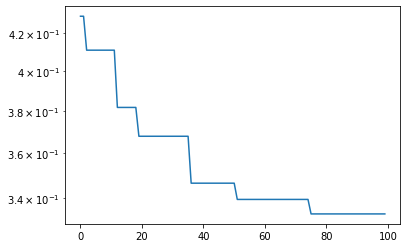

In [4]:
best,trash=paretoEvolve(data,response)

In [15]:
varConst

[array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
        0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
        1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
        1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
        2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
        3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
        3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
        4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
        5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
        5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531]),
 -2,
 -1,
 1,
 2]

In [3]:
varConst=[data[0],-2,-1,1,2]
evalProg(best,varConst)

NameError: name 'best' is not defined

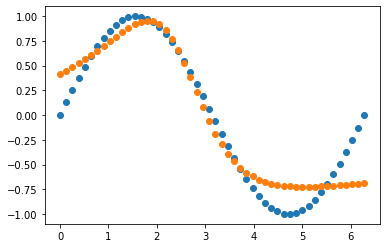

In [14]:
align=alignModel(best,varConst,response)
plt.scatter(data[0],response)
plt.scatter(data[0],alignedEvalProg(best,varConst,align))

In [132]:
paretoTournament(population,varConst,response)

[[[0, 2, 8, 5],
  [1, 0, 6, 11],
  [1, 2, 9, 10],
  [1, 2, 10, 4],
  [1, 0, 10, 11],
  [1, 3, 3, 10],
  [1, 3, 12, 5],
  [0, 0, 9, 4],
  [1, 1, 8, 5],
  [1, 0, 9, 0],
  [1, 1, 12, 0],
  [1, 1, 0, 8],
  [0, 2, 6, 12]],
 [[1, 1, 4, 1],
  [1, 0, 3, 12],
  [1, 3, 3, 8],
  [0, 0, 6, 6],
  [1, 0, 6, 12],
  [1, 3, 3, 7],
  [1, 0, 8, 1],
  [1, 2, 9, 7],
  [1, 1, 12, 9],
  [1, 3, 12, 6],
  [1, 0, 11, 5],
  [1, 3, 6, 3],
  [0, 3, 1, 10],
  [0, 2, 4, 2],
  [0, 2, 8, 0],
  [0, 3, 3, 4],
  [1, 1, 12, 12],
  [0, 3, 10, 11],
  [0, 2, 4, 1],
  [0, 3, 4, 10],
  [1, 3, 5, 11],
  [1, 3, 3, 11],
  [1, 3, 3, 0],
  [1, 1, 12, 6],
  [1, 3, 5, 9],
  [0, 2, 0, 6],
  [0, 1, 12, 5],
  [1, 3, 12, 4],
  [1, 3, 3, 12],
  [1, 3, 4, 2],
  [0, 0, 8, 3],
  [1, 1, 10, 2],
  [1, 1, 9, 1],
  [1, 2, 0, 4],
  [1, 2, 3, 2],
  [0, 0, 7, 10],
  [0, 2, 0, 10],
  [0, 2, 11, 3],
  [0, 3, 6, 10],
  [0, 2, 8, 0],
  [0, 1, 9, 11],
  [1, 3, 11, 5],
  [1, 2, 9, 6],
  [1, 1, 4, 0],
  [0, 1, 10, 9],
  [0, 2, 2, 12],
  [0, 0, 6, 10],
  [

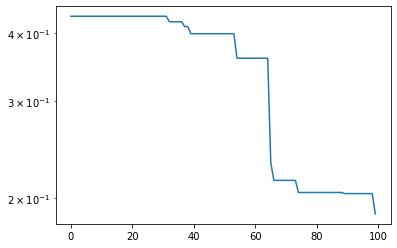

In [74]:
best,pop=evolve(data,response)

In [77]:
print(fitness(best,data,response))
print(len(best))

0.18704928151673905
26


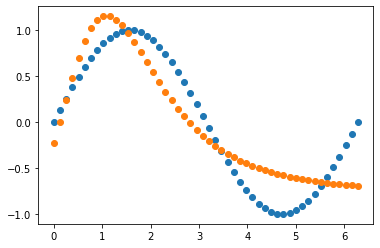

In [76]:
align=alignModel(best,data,response)
plt.scatter(data,response)
plt.scatter(data,alignedEvalProg(best,data,align))

## Evolve using Pareto tournaments

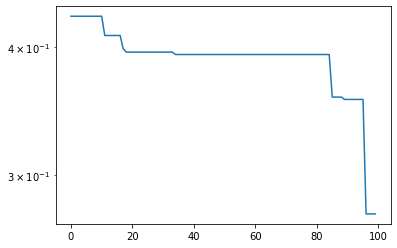

0.27469284795522186


In [16]:
best,pop=paretoEvolve(data,response)
print(fitness(best,varConst,response))

In [17]:
varConst

[array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
        0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
        1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
        1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
        2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
        3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
        3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
        4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
        5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
        5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531]),
 -2,
 -1,
 1,
 2]

In [18]:
print(fitness(best,varConst,response))
print(len(best))

0.27469284795522186
35


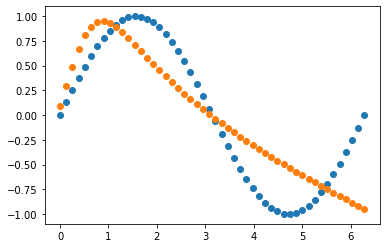

In [21]:
align=alignModel(best,varConst,response)
plt.scatter(data,response)
plt.scatter(data,alignedEvalProg(best,varConst,align))

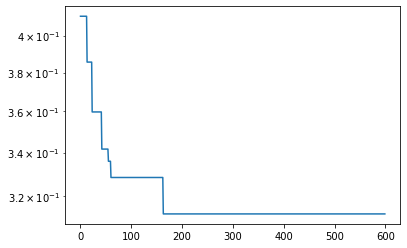

IndexError: list index out of range

In [23]:
best,pop=paretoEvolve(data,response,generations=600)

0.31222372924729336


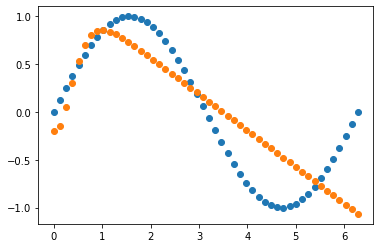

In [25]:
print(fitness(best,varConst,response))
align=alignModel(best,varConst,response)
plt.scatter(data,response)
plt.scatter(data,alignedEvalProg(best,varConst,align))

In [ ]:
len(best)

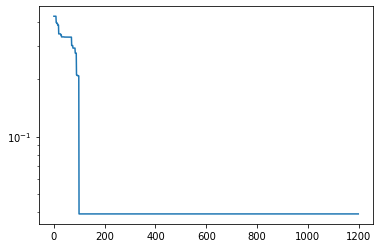

0.03918306124265747


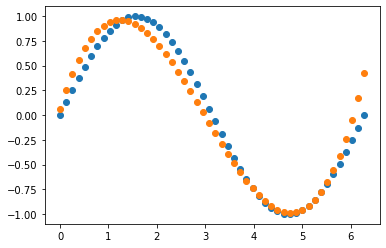

In [39]:
best,pop=paretoEvolve(data,response,generations=1200)
print(fitness(best,varConst,response))
align=alignModel(best,varConst,response)
plt.scatter(data,response)
plt.scatter(data,alignedEvalProg(best,varConst,align))

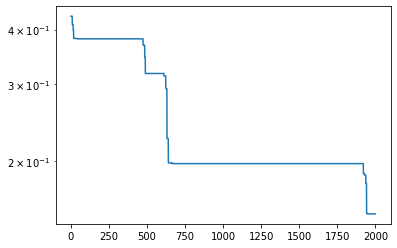

0.1512887072650766


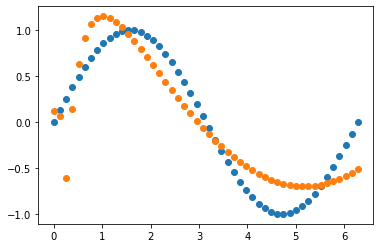

In [54]:
best,pop=paretoEvolve(data,response,generations=2000)
print(fitness(best,varConst,response))
align=alignModel(best,varConst,response)
plt.scatter(data,response)
plt.scatter(data,alignedEvalProg(best,varConst,align))

## 2 Variable Problems

In [3]:
data=[np.linspace(-4.98855,-62.0033,50),np.linspace(-35.2159,-77.8499,50),np.linspace(61.6466,-81.7417,50),np.linspace(25.7519,-89.7831,50),np.linspace(-71.2552,-92.1165,50),np.linspace(98.2881,76.7794,50),np.linspace(12.3118,-59.6275,50),np.linspace(27.441,-58.1894,50),np.linspace(74.8038,-9.53367,50),np.linspace(-71.2121,-97.6116,50),np.linspace(-6.05205,1.19606,50),np.linspace(10.3939,21.0286,50),np.linspace(-58.0995,18.7283,50),np.linspace(43.5429,-51.5061,50),np.linspace(30.3093,-45.0866,50),np.linspace(-73.6376,10.0935,50),np.linspace(-14.705,-94.9309,50),np.linspace(-8.73351,64.3492,50),np.linspace(-29.5301,34.0576,50),np.linspace(-99.9332,-50.9552,50),np.linspace(-71.3998,-16.1525,50),np.linspace(-47.7467,-93.6815,50),np.linspace(-16.7259,55.4985,50),np.linspace(11.951,-12.1252,50),np.linspace(-5.50228,-65.2755,50),np.linspace(32.7053,-46.3588,50),np.linspace(72.2501,-72.8581,50),np.linspace(95.225,-32.7453,50),np.linspace(30.1933,10.3258,50),np.linspace(53.9494,58.0914,50),np.linspace(44.6746,23.1943,50),np.linspace(40.299,45.5977,50),np.linspace(76.514,0.90986,50),np.linspace(97.2868,-48.4395,50),np.linspace(49.4418,22.5081,50),np.linspace(77.1796,-8.16409,50),np.linspace(25.5188,66.678,50),np.linspace(68.6443,79.5436,50),np.linspace(10.5295,26.0651,50),np.linspace(84.3267,0.857262,50),np.linspace(32.761,-82.6561,50),np.linspace(39.1207,14.8221,50),np.linspace(-16.7103,46.2982,50),np.linspace(82.4914,57.636,50),np.linspace(-61.8365,-15.4132,50),np.linspace(-58.4585,94.5686,50),np.linspace(-8.09376,-89.1223,50),np.linspace(51.8036,-77.6242,50),np.linspace(-1.36246,68.6977,50),np.linspace(48.1884,86.2951,50),np.linspace(-44.0958,72.1412,50),np.linspace(34.24,-30.2747,50),np.linspace(-27.2211,-23.9313,50),np.linspace(-27.1271,-6.07211,50),np.linspace(-79.4505,10.4568,50),np.linspace(-35.5549,12.2003,50),np.linspace(59.8827,83.6902,50),np.linspace(-45.4037,88.8708,50),np.linspace(59.5554,16.0376,50),np.linspace(-84.9545,-23.5107,50),np.linspace(59.2968,-43.5126,50),np.linspace(57.3777,43.4278,50),np.linspace(11.2829,-99.0912,50),np.linspace(48.8211,-92.8678,50),np.linspace(94.7488,-87.9666,50),np.linspace(-51.6994,51.325,50),np.linspace(-26.9748,-21.9465,50),np.linspace(22.2136,-63.5886,50),np.linspace(-88.7735,-60.2759,50),np.linspace(-27.3579,-38.2693,50),np.linspace(-16.9044,1.41234,50),np.linspace(24.0197,-23.8247,50),np.linspace(-51.3522,-96.0076,50),np.linspace(22.7716,4.93855,50),np.linspace(13.8495,0.655103,50),np.linspace(79.2692,-8.32269,50),np.linspace(80.9756,-47.8681,50),np.linspace(-51.1411,63.0108,50),np.linspace(64.2629,11.2569,50),np.linspace(18.0617,67.2005,50),np.linspace(-82.8896,28.3226,50),np.linspace(-79.4616,73.255,50),np.linspace(-63.5722,3.4325,50),np.linspace(97.6641,12.3589,50),np.linspace(75.0106,-83.6659,50),np.linspace(34.47,48.2079,50),np.linspace(45.1058,38.3343,50),np.linspace(77.5641,-18.7487,50),np.linspace(-86.761,72.0589,50),np.linspace(58.0815,27.8542,50),np.linspace(-40.7211,47.788,50),np.linspace(10.4265,-77.5653,50),np.linspace(29.8995,-27.0876,50),np.linspace(-92.2554,52.793,50),np.linspace(64.8302,61.6727,50),np.linspace(49.8019,-99.442,50),np.linspace(24.772,-94.7964,50),np.linspace(31.3705,-45.4271,50),np.linspace(-41.821,16.2672,50),np.linspace(60.8102,-28.1735,50),np.linspace(-40.7175,-97.5372,50)]
response=((data[35])**4 *((data[77])**2-1. *(data[8]))**2 *data[82])/((data[23])**2 *(data[79])**4 *(data[8])**2 *(data[14]+data[56]+data[8])**2 *(3.14159 -1. *data[93])**2)
varConst=copy.deepcopy(data)
varConst[len(varConst):]=[-2,-1,1,2]

/Users/nathanhaut/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


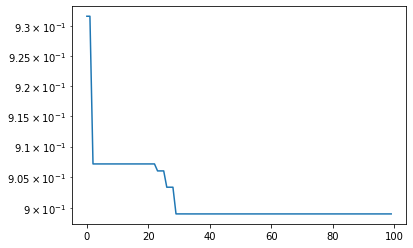

In [4]:
best,pop=paretoEvolve(data,response)

In [5]:
fitness(best,varConst,response)

0.8990214382960182

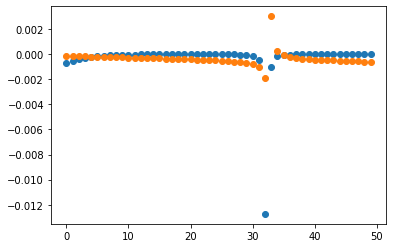

In [6]:
align=alignModel(best,varConst,response)
plt.scatter(range(len(data[0])),response)
plt.scatter(range(len(data[0])),alignedEvalProg(best,varConst,align))

In [7]:
len(best)

12

In [120]:
response

array([-6.90951126e-04, -5.15733114e-04, -3.87334550e-04, -2.92203621e-04,
       -2.21048520e-04, -1.67393800e-04, -1.26660070e-04, -9.55656238e-05,
       -7.17303700e-05, -5.34093433e-05, -3.93107284e-05, -2.84699016e-05,
       -2.01611777e-05, -1.38353127e-05, -9.07485742e-06, -5.56207949e-06,
       -3.05591282e-06, -1.37559037e-06, -3.89506404e-07, -8.65776531e-09,
       -1.85090207e-07, -9.18283165e-07, -2.28240458e-06, -4.56081422e-06,
       -1.08891745e-05, -8.05981906e-06, -1.47267668e-05, -2.37649444e-05,
       -3.89074415e-05, -6.87093934e-05, -1.43906968e-04, -4.60154684e-04,
       -1.27360529e-02, -1.01215623e-03, -1.73232442e-04, -6.20750710e-05,
       -2.85386341e-05, -1.46779549e-05, -7.93929238e-06, -4.35199232e-06,
       -2.35172699e-06, -1.22636687e-06, -6.23020434e-07, -4.76974203e-07,
       -7.73139859e-10, -1.30858615e-09, -5.77320148e-09,  2.04261822e-08,
        1.36411800e-07,  4.25447137e-07])

In [98]:
alignedEvalProg(best,varConst,align)

array([104.93131059,  99.88136372,  94.62608396,  89.34080404,
        84.12659812,  79.04583113,  74.13907052,  69.43384423,
        64.94949004,  60.69999068,  56.69570744,  52.9444813 ,
        49.4523553 ,  46.22406195,  43.26336021,  40.57327359,
        38.15626165,  36.01434558,  34.14920174,  32.56223218,
        31.25461853,  30.22736369,  29.4813244 ,  29.0172369 ,
        28.83573742,  28.93737861,  29.3226428 ,  29.99195287,
        30.94568112,  32.1841566 ,  33.70767124,  35.51648493,
        37.61082979,  39.9909138 ,  42.65692383,  45.60902829,
        48.84737932,  52.37211473,  56.18335964,  60.28122791,
        64.66582337,  69.33724092,  74.29556745,  79.54088268,
        85.07325988,  90.89276652,  96.9994648 , 103.39341219,
       110.07466187, 117.04326309])

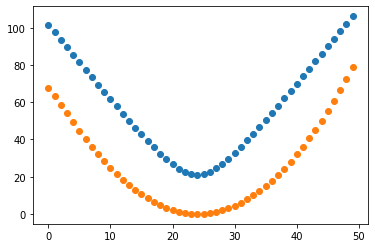

In [105]:
align=alignModel(best,varConst,response)
plt.scatter(range(len(data[0])),response)
plt.scatter(range(len(data[0])),.007*evalProg(best,varConst))

In [101]:
align

array([7.84655289e-03, 2.88511338e+01])